In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Rotación y traslación de imágenes
## David Omar Paredes Paredes y Abraham Maximiliano Ávalos Corrales

# Image functions


In [2]:
image = cv2.imread('/content/drive/Shareddrives/TrabajoOpti2/RotacionTraslacion/panamericana1.png')
image2 = cv2.imread('/content/drive/Shareddrives/TrabajoOpti2/RotacionTraslacion/panamericana2.png')

In [3]:
print(image.shape[1])

450


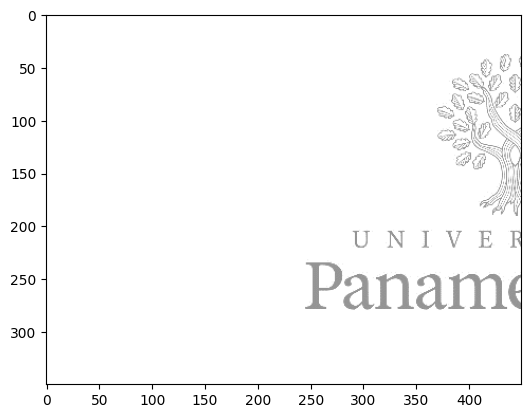

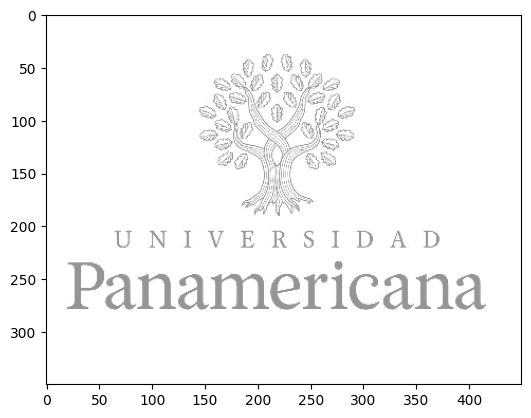

In [4]:
def transform_image(img, tx, ty, angle, scale):
  # Define the translation matrix
  # X-translation (positive moves right)
  # Y-translation (positive moves down)
  translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])

  # Define the rotation matrix
  height, width = image.shape[:2]
  center = (width/2, height/2)
  rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=scale)

  # mix rotation & translation matrix
  rot_hom = np.append(rotate_matrix, [[0, 0, 1]], axis=0) # in homogeneous coordinates
  tr_hom = np.append(translation_matrix, [[0, 0, 1]], axis=0)
  rt_mat = rot_hom@tr_hom

  # Apply the translation
  out = cv2.warpAffine(image, rt_mat[:2,:], (width,height), borderValue=(255, 255, 255))
  return out

transformed_image = transform_image(image, 450/2, 0 , 0, 1)
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
def image_difference(image1, image2):
    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same dimensions")

    # Compute the absolute difference between the two images
    diff = cv2.absdiff(image1, image2)

    # Calculate the percentage of differing pixels
    total_pixels = np.prod(image1.shape[:2])
    differing_pixels = np.count_nonzero(diff)
    percentage = (differing_pixels / total_pixels)

    return percentage

In [6]:
dif = image_difference(image, image2)
print(dif)

0.5211238095238095


8884 8595
0.032530391715443474


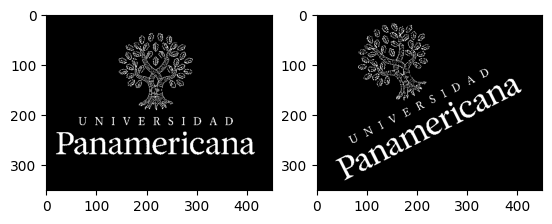

In [7]:
def whitespace_difference(refImage, generatedImage, thresh=200, type=cv2.THRESH_BINARY_INV, _print=False):
  # Ensure both images have the same dimensions
  if refImage.shape != generatedImage.shape:
    raise ValueError("Both images must have the same dimensions")

  ref_bw = cv2.cvtColor(refImage,       cv2.COLOR_BGR2GRAY)
  gen_bw = cv2.cvtColor(generatedImage, cv2.COLOR_BGR2GRAY)

  _, ref_bw = cv2.threshold(ref_bw, thresh, 1, type)
  _, gen_bw = cv2.threshold(gen_bw, thresh, 1, type)

  ref_npixels = np.count_nonzero(ref_bw)
  gen_npixels = np.count_nonzero(gen_bw)

  # Check
  if(_print):
    print(ref_npixels, gen_npixels)
    plt.subplot(1,2,1)
    plt.imshow(ref_bw,'gray',vmin=0,vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(gen_bw,'gray',vmin=0,vmax=1)

  return 1-gen_npixels/ref_npixels

dif = whitespace_difference(image, image2, _print=True)
print(dif)

8595 4928
0.42664339732402556


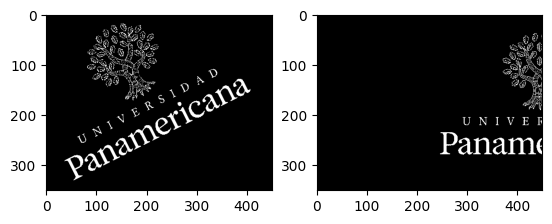

In [8]:
dif = whitespace_difference(image2, transformed_image, _print=True)
print(dif)

# Solver y planteamiento del problema

### EP Problem

In [9]:
class ESproblem:
  def __init__(self, one_step_size:bool = False):
    self.one_step_size = one_step_size

  def generate_initial_population(self, p_size) -> list:...#
  def _compare(self, fitness_a, fitness_b) -> int:...

  def mutate(self, g, tau:float, tau2:float, eps:float):#
    g_len = len(g)
    newg  = np.copy(g)

    if self.one_step_size:
      n_x   = g_len - 1

      sigma = newg[n_x] = sigma*np.exp(np.random.normal(0, tau))
      for i in range(n_x):
        newg[i] = newg[i] + np.random.normal(0, sigma)
    else:
      n_x   = int(g_len / 2)
      newg_x = newg[:n_x]
      newg_s = newg[n_x:]

      for i in range(n_x):
        newg_s[i] = max(
            abs(
                newg_s[i]*np.exp(np.random.normal(0, tau) + np.random.normal(0, tau2))
            ),
            eps
        )
        newg_x[i] = newg_x[i] + np.random.normal(0, newg_s[i])

    return newg
  def update_sigma(self, G, c):
    if self.one_step_size:
      G[:, -1] *= c
    else:
      n_x = len(G[0])
      G[:, n_x:] *= c
  # ----- update_sigma
  def check_individual_integrity(self, g) -> bool: return True

  def get_fitness(self, G:list, F:list=None):...#
  def get_elite(self, G:list, F:list) -> (list, list):...#
  def update_elite(self, E, newE, Fe, newFe):...#

  def solved(self, Fe:list): return False#
  def has_progress_metric(self) -> bool: return False
  def get_progress_metric(self, F:list) -> float:...
  def get_progress_max(self) -> float:...
  def get_variation(self, F:list) -> float:...
  def custom_print(self, G, F, elite, Fe):...


## imageTransformationES

In [10]:
class imageTransformationES(ESproblem):
  def __init__(self, specie_size, path_start_image, path_target_image):
    super().__init__(False)
    self.specie_size = specie_size
    self.start_image = cv2.imread(path_start_image)
    self.target_image = cv2.imread(path_target_image)
    self.image_height = self.start_image.shape[0]
    self.image_width = self.start_image.shape[1]

  def generate_initial_population(self, p_size):
    pop = np.zeros((p_size, self.specie_size))
    mid_specie = self.specie_size/2
    pop[:, 0] = np.random.normal(0, self.image_width/4,(p_size)) #delta x
    pop[:, 1] = np.random.normal(0, self.image_height/4,(p_size)) #delta y
    pop[:, 2] = np.random.normal(0, 90,(p_size)) #rotation
    pop[:, 3] = np.random.normal(1, 0.5,(p_size)) #scale
    pop[:, 4] = np.random.uniform(1, self.image_width/10,(p_size))
    pop[:, 5] = np.random.uniform(1, self.image_height/10,(p_size))
    pop[:, 6] = np.random.uniform(1, 5,(p_size))
    pop[:, 7] = np.random.uniform(0.01,0.05,(p_size))
    return pop

  def transform_image(self, img, tx, ty, angle, scale):
    # Define the translation matrix
    # X-translation (positive moves right)
    # Y-translation (positive moves down)
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])

    # Define the rotation matrix
    height, width = image.shape[:2]
    center = (width/2, height/2)
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=scale)

    # mix rotation & translation matrix
    rot_hom = np.append(rotate_matrix, [[0, 0, 1]], axis=0) # in homogeneous coordinates
    tr_hom = np.append(translation_matrix, [[0, 0, 1]], axis=0)
    rt_mat = rot_hom@tr_hom

    # Apply the translation
    out = cv2.warpAffine(image, rt_mat[:2,:], (width,height), borderValue=(255, 255, 255))
    return out

  def image_difference(self, image1, image2):
    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same dimensions")

    # Compute the absolute difference between the two images
    diff = cv2.absdiff(image1, image2)

    # Calculate the percentage of differing pixels
    total_pixels = np.prod(image1.shape[:2])
    differing_pixels = np.count_nonzero(diff)
    percentage = (differing_pixels / total_pixels)
    return percentage

  def whitespace_difference(self, refImage, generatedImage, thresh=200, type=cv2.THRESH_BINARY_INV, _print=False):
    # Ensure both images have the same dimensions
    if refImage.shape != generatedImage.shape:
      raise ValueError("Both images must have the same dimensions")

    ref_bw = cv2.cvtColor(refImage,       cv2.COLOR_BGR2GRAY)
    gen_bw = cv2.cvtColor(generatedImage, cv2.COLOR_BGR2GRAY)

    _, ref_bw = cv2.threshold(ref_bw, thresh, 1, type)
    _, gen_bw = cv2.threshold(gen_bw, thresh, 1, type)

    ref_npixels = np.count_nonzero(ref_bw)
    gen_npixels = np.count_nonzero(gen_bw)

    # Check
    if(_print):
      print(ref_npixels, gen_npixels)
      plt.subplot(1,2,1)
      plt.imshow(ref_bw,'gray',vmin=0,vmax=1)
      plt.subplot(1,2,2)
      plt.imshow(gen_bw,'gray',vmin=0,vmax=1)

    return np.abs(1-gen_npixels/ref_npixels)

  def show_images_comparison(self, ind):
    img = self.transform_image(self.start_image , ind[0], ind[1], ind[2], ind[3])
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB))
    plt.show()

  def custom_print(self, G, F, elite, Fe):
    self.show_images_comparison(elite)

  def get_fitness(self, G):
    pop_fitn = np.zeros(G.shape[0])

    for idx, ind in enumerate(G):
      transformed_image = self.transform_image(self.start_image , ind[0], ind[1], ind[2], ind[3])
      coincidence = self.image_difference(self.target_image, transformed_image)
      pixel_proportion = self.whitespace_difference(self.target_image,transformed_image)
      pop_fitn[idx] = coincidence*0.5 + pixel_proportion*0.5

    return pop_fitn

  def get_elite(self, G, F):
    lowest_diff = np.argmin(F)#F.index(min(F))
    return np.copy(G[lowest_diff]), F[lowest_diff]

  def solved(self, F):
    if(np.min(F)==0.0):
      return True
    return False

  def intemediate_recombination(self, newG):
    p1_idx = np.random.randint(0, newG.shape[0] )
    p2_idx = np.random.randint(0, newG.shape[0] )

    while p1_idx == p2_idx:
      p2_idx = np.random.randint(0, newG.shape[0] )

    p1 = np.copy(newG[p1_idx])
    p2 = np.copy(newG[p2_idx])

    offspring = np.array((p1+p2)/2)

    return offspring

  def update_elite(self, elite, newElite, Fe, newFe):
      if(newFe<Fe):
        return np.copy(newElite), newFe
      return np.copy(elite), Fe

  def has_progress_metric(self) -> bool: return True
  def get_progress_max(self) -> float:   return 1.0
  def get_progress_metric(self, F) -> float:
    return 1.0 - F
  def get_variation(self, F: list) -> float:
    return np.std(F)

## solverES

In [11]:
class solverES:
  def __init__(
      self,
      problem: ESproblem,
      lambdaV:int,
      tau:float  = None,
      tau2:float = None,
      alpha:float= 0.2,
      eps:float  = 0.001,
      p_size:int = 50,
      max_it:int = 1000,
      sigma_reset_interval   = 50,
      target_mut_ratio: float= 1.0/5.0,
      c:float = 0.817
      # Formatting options for progress bar
      ,FEEDBACK_INT:int = 10
      ,MAX_F_LEN:int    = 30
      ,MAX_K_LEN:int    = 20
      ,MAX_G_LEN:int    = 10
      ,SPINNER:list[str]= ['\\', '|', '/', '-']
      ,verbose:bool     = False
      ,use_custom_print:bool= False
  ):
      self.problem = problem
      self.eps     = eps
      self.p_size  = p_size
      self.max_it  = max_it
      self.tau     = tau
      self.sigma_reset_interval = sigma_reset_interval
      self.target_mut_ratio     = target_mut_ratio
      self.successfull_mut_ratio= 1.0
      self.c       = c
      self.lambdaV = lambdaV
      self.alpha   = alpha

      if tau is None:
        self.tau = 1/np.sqrt(p_size)
      self.tau2    = tau2
      if tau2 is None:
        self.tau2 = 1/np.sqrt(2*np.sqrt(p_size))

      # Formatting options for progress bar
      self.FEEDBACK_INT = FEEDBACK_INT
      self.MAX_F_LEN    = MAX_F_LEN
      self.MAX_K_LEN    = MAX_K_LEN
      self.MAX_G_LEN    = MAX_G_LEN
      self.SPINNER      = SPINNER
      self.SPINNER_LEN  = len(self.SPINNER)
      self.verbose      = verbose
      self.use_custom_print= use_custom_print

      # solve() variables
      self.G = None
      self.F = None
      self.elite = None
      self.Fe = None
      self.n_it = 0
      self.converged = False

  def _print_progress(self, n_k:int):
    if self.verbose:
      print(f'\nIteration: {n_k}/{self.max_it}')
      if self.use_custom_print:
        self.problem.custom_print(self.G, self.F, self.elite, self.Fe)
      else:
        print(f'///Population///')
        print(self.G[: min(len(self.G), self.MAX_G_LEN) ], end='\n\n')
        print(self.F[: min(len(self.F), self.MAX_G_LEN) ])
        print(f'///Elite///')
        print(self.elite, end='\n\n')
        print(self.Fe)
    else:
      spinner_idx:int = int(n_k/self.FEEDBACK_INT)%self.SPINNER_LEN
      k_percentage    = n_k/float(self.max_it)*100
      filled_k        = int(self.MAX_K_LEN *n_k // self.max_it)
      k_bar           = '#'*filled_k + '-'*(self.MAX_K_LEN - filled_k)

      print(f'\r{self.SPINNER[spinner_idx]}', end='')
      print(f' Iteration:[{k_bar}]{k_percentage:.2f}%', end=' ')
      print(f'SMR:{self.successfull_mut_ratio:.2f}', end=' ')

      if self.problem.has_progress_metric():
        progress = self.problem.get_progress_metric(self.Fe)
        filled_p = int(self.MAX_F_LEN * progress // self.problem.get_progress_max())
        p_bar = '#'*filled_p + '-'*(self.MAX_F_LEN - filled_p)
        variation = self.problem.get_variation(self.F)

        print(f'Fitness:[{p_bar}]pm {variation:.2f}', end='')
      #----------
      else: print(f'Fitness: {self.Fe}', end='')
  # end _print_progress

  def solve(self): #-------------------------------------------------------SOLVE
    self.G = self.problem.generate_initial_population(self.p_size)
    self.F = self.problem.get_fitness(self.G)
    self.elite, self.Fe = self.problem.get_elite(self.G, self.F)

    self._print_progress(0)

    n_mut = 0
    successfull_mut = 0

    for k in range(1, self.max_it+1):
      self.n_it = k
      if self.problem.solved(self.Fe) or self.successfull_mut_ratio < self.eps:
        self._print_progress(k)
        self.converged = True
        break
      # print(k)
      # Generate offspring
      g_shape = self.G.shape
      newG = np.zeros((self.lambdaV, g_shape[1]))

      for i, species in enumerate(newG):
        newG[i] = self.problem.intemediate_recombination(self.G)

      offspringF = self.problem.get_fitness(newG)

      for i, species in enumerate(newG):
        newG[i] = self.problem.mutate(species, self.tau, self.tau2, self.eps)
        n_mut += 1

      newF = self.problem.get_fitness(newG)

      # 1/5 Rule
      successfull_mut += np.count_nonzero(newF < offspringF)
      if k%self.sigma_reset_interval == 0:
        self.successfull_mut_ratio = successfull_mut / n_mut
        if self.successfull_mut_ratio > self.target_mut_ratio:
          problem.update_sigma(newG, 1.0/self.c)
        elif self.successfull_mut_ratio < self.target_mut_ratio:
          problem.update_sigma(newG, self.c)
        successfull_mut = 0
        n_mut           = 0

      Gconcat = np.concatenate([self.G, newG])
      Fconcat = np.concatenate([self.F, newF])
      best    = np.argsort(Fconcat)

      self.G = np.copy(Gconcat[best[:self.p_size]])
      self.F = self.problem.get_fitness(self.G)
      newElite, newFe = self.problem.get_elite(self.G, self.F)

      self.elite, self.Fe = self.problem.update_elite(self.elite, newElite, self.Fe, newFe)

      # print("Elite: ",self.elite, " FE: ",self.Fe  )
      # self.problem.show_images_comparison(self.elite)
      if k%self.FEEDBACK_INT == 1 or k==self.max_it:
        self._print_progress(k)
        # self.problem.show_images_comparison(self.elite)
      # end for



# Test


In [12]:
problem = imageTransformationES(
    8,
    '/content/drive/Shareddrives/TrabajoOpti2/RotacionTraslacion/panamericana1.png',
    '/content/drive/Shareddrives/TrabajoOpti2/RotacionTraslacion/panamericana2.png'
)

coincidence = problem.image_difference(problem.target_image, image2)
pixel_proportion = problem.whitespace_difference(problem.target_image, image2)
fit = coincidence*0.5 + pixel_proportion*0.5
print(coincidence)
print(pixel_proportion)
print(problem.get_progress_metric(fit))

0.0
0.0
1.0


In [13]:
solver = solverES(
    problem,
    lambdaV = 500,
    alpha = 0.2, eps=0.01,
    p_size=100, max_it=1000,
    FEEDBACK_INT=5, sigma_reset_interval=10,
    verbose=False,
    use_custom_print=False
)
solver.solve()

/ Iteration:[#-------------------]7.10% SMR:0.00 Fitness:[#######################-------]pm 0.01

[-1.67510348e+01 -4.10044337e+01  2.65533096e+01  1.01427481e+00
  3.40164203e+01  1.37056327e+01  3.64725672e+00  1.55782122e-02]


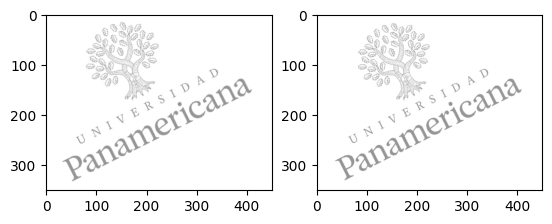

In [14]:
print(solver.elite)
problem.show_images_comparison(solver.elite)
